In [1]:
import sys

DIR = "/workspaces/ts-forecasting/"

sys.path.append("/workspaces/ts-forecasting")
sys.path.append("/app")

In [2]:
from src.psql import PostgresDB

db = PostgresDB()

In [3]:
df = db.table_to_df("stock_data")

print(f"Unique stocks: {df.ticker.unique()}")
df.head(5)

Unique stocks: ['AAPL' 'GOOGL' 'MSFT' 'AMZN' 'TSLA' 'NVDA']


,ticker,ts,open,high,low,close,vwap,transactions
0,AAPL,2024-07-01 08:00:00+00:00,211.89,211.89,211.04,211.09,211.4229,1316
1,AAPL,2024-07-01 09:00:00+00:00,211.09,211.39,210.50,210.99,210.8973,1732
2,AAPL,2024-07-01 10:00:00+00:00,211.19,211.51,211.15,211.15,211.2866,286
3,AAPL,2024-07-01 11:00:00+00:00,211.14,211.66,211.14,211.65,211.4742,1135
4,AAPL,2024-07-01 12:00:00+00:00,211.32,212.20,210.62,211.45,211.2834,4964


In [4]:
pv = df.pivot(index="ts", columns="ticker", values="vwap")
pv = pv.ffill()

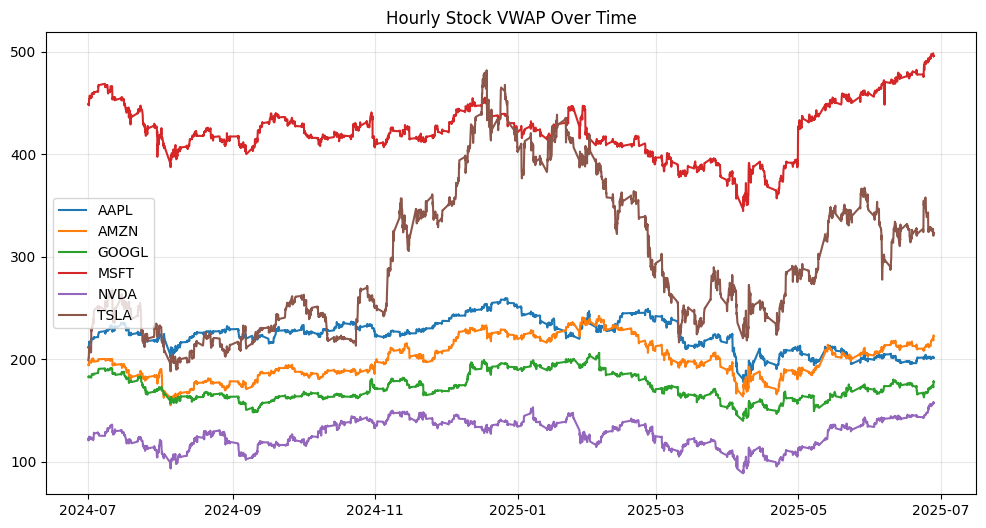

In [ ]:
pv = df.pivot(index="ts", columns="ticker", values="vwap")
pv = pv.ffill()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.title("Hourly Stock VWAP Over Time")

for c in pv.columns:
    plt.plot(pv.index, pv[c], label=c)

plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [49]:
import torch
import pandas as pd
import random

from torch.utils.data import Dataset
from typing import Union, Dict

class StockDataset(Dataset):
    def __init__(self, df: pd.DataFrame, lookback: int = 30, normalizing_meta: Union[None, Dict] = None):
        self.lookback = lookback

        self.data = []
        self.data_lens = {}
        self.data_meta = {}

        self.idx_to_ticker = {}
        self.ticker_to_idx = {}
        
        for i, c in enumerate(df.columns):
            if not pd.api.types.is_numeric_dtype(df[c]):
                raise TypeError(f"Column '{c}' must be numeric.")

            sub = torch.tensor(df[c].values, dtype=torch.float32)

            m_cur, s_cur = sub.mean(), sub.std()
            self.data_meta[i] = (m_cur, s_cur)

            if normalizing_meta is not None:
                m, s = normalizing_meta[i]

            else:
                m, s = m_cur, s_cur

            sub = (sub - m) / s

            self.data.append((i, sub))
            self.data_lens[i] = len(sub)

            self.idx_to_ticker[i] = c
            self.ticker_to_idx[c] = i

        self.n = sum(self.data_lens.values()) + (- self.lookback + 1) * len(self.data_lens)


    def __len__(self):
        return 100000

    def __getitem__(self, _):
        ticker_i = random.randint(0, len(self.data) - 1)
        idx = random.randint(self.lookback, len(self.data[ticker_i][1]) - 1)

        ticker_i = 0
        idx = self.lookback

        ticker_ind, data = self.data[ticker_i]

        ticker_ind = torch.tensor([ticker_ind], dtype=torch.float32)

        return torch.cat((ticker_ind, data[idx - self.lookback:idx])), data[idx-1]
    

In [51]:
from torch.utils.data import DataLoader

stock_dataset = StockDataset(pv)
stock_loader = DataLoader(
    stock_dataset,
    batch_size=2,
    pin_memory=True,
    shuffle=True,
)

train_dataset = StockDataset(pv[pv.index < "2025-04-01"])

valid_dataset = StockDataset(
    pv[("2025-01-01" <= pv.index) & (pv.index < "2025-05-01")],
    normalizing_meta=train_dataset.data_meta,
)
test_dataset = StockDataset(
    pv[pv.index >= "2025-05-01"],
    normalizing_meta=train_dataset.data_meta,
)

In [52]:
X, y = next(iter(stock_dataset))

print(X)
print(y)
print("Target inside input:", y.item(), "vs", X[-1].item())

tensor([ 0.0000, -0.7406, -0.7741, -0.7493, -0.7373, -0.7495, -0.6461, -0.5471,
        -0.5064, -0.4170, -0.3811, -0.4432, -0.4347, -0.3992, -0.3973, -0.3867,
        -0.4066, -0.4347, -0.4618, -0.4519, -0.4632, -0.4596, -0.3957, -0.2687,
        -0.2103, -0.2512, -0.2293, -0.1999, -0.2015, -0.1817, -0.2220])
tensor(-0.2220)
Target inside input: -0.22204940021038055 vs -0.22204940021038055


In [47]:
import torch.nn as nn


class ExperimentalModel(nn.Module):
    def __init__(
        self,
        lookback,
        num_embeddings,
        hidden_size=64,
        output_size=1,
        embedding_dim=16,
        dropout_rate = 0.1
    ):
        super(ExperimentalModel, self).__init__()

        self.lookback = lookback
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding_dim = embedding_dim

        # self.embedding = nn.Embedding(
        #     num_embeddings=num_embeddings,
        #     embedding_dim=self.embedding_dim,
        # )
        # self.embedding_dropout = nn.Dropout(dropout_rate)

        self.fc1 = nn.Linear(self.lookback, self.hidden_size)
        self.relu = nn.ReLU()
        self.dropout_1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, X):
        ticker_ind, d = X[:, 0:1], X[:, 1:]

        # cusip_embedding_vectors = self.embedding(ticker_ind.long()).reshape(-1, self.embedding_dim)
        # cusip_embedding_vectors = self.embedding_dropout(cusip_embedding_vectors)

        # d = torch.cat((d, cusip_embedding_vectors), dim=1)

        d = self.fc1(d)
        d = self.relu(d)
        d = self.dropout_1(d)
        d = self.fc2(d)

        return d

In [53]:
import torch.nn as nn

from datetime import datetime
from pytz import timezone

CT = timezone("America/Chicago")

# model = nn.Sequential(
#     nn.Linear(30 + 1, 1)  # +1 for ticker index
# )

hyperparameters = {
    "desc": "Includes embedding and linear layers.",
    "batch_size": 128,
    "learning_rate": 0.01,
    "n_updates": 1000,
    "checkpoint_iter": 2000,
    "lookback": 30,
    "hidden_size": 64,
    "embedding_dim": 64,
    "model_dir": f"models/{datetime.now(CT).strftime('%Y-%m-%d %H:%M')}/"
}

model = ExperimentalModel(
    num_embeddings=len(stock_dataset.ticker_to_idx),
    lookback=hyperparameters["lookback"],
    hidden_size=hyperparameters["hidden_size"],
    embedding_dim=hyperparameters["embedding_dim"],
    dropout_rate=0
)

opt = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.MSELoss()

for i in range(5000):
    x, y = stock_dataset[0]
    x = x.unsqueeze(0)  # Add batch dim
    y = torch.tensor([[y]])  # Make it (1, 1)

    pred = model(x)
    loss = loss_fn(pred, y)

    opt.zero_grad()
    loss.backward()
    opt.step()

    # for name, param in model.named_parameters():
    #     if param.grad is None:
    #         print(f"{name} has no grad!")
    #     else:
    #         print(f"{name} grad norm: {param.grad.norm().item()}")

    # with torch.no_grad():
    #     print("Sample weights:", list(model.parameters())[0][0][:5])  # See if weights are blowing up
    #     print("Prediction:", model(x).item(), "Target:", y.item())
        
    if i % 500 == 0:
        print(f"Step {i}, loss: {loss.item():.6f}")
        print(x)
        print(y)

Step 0, loss: 0.121558
tensor([[ 0.0000, -0.7406, -0.7741, -0.7493, -0.7373, -0.7495, -0.6461, -0.5471,
         -0.5064, -0.4170, -0.3811, -0.4432, -0.4347, -0.3992, -0.3973, -0.3867,
         -0.4066, -0.4347, -0.4618, -0.4519, -0.4632, -0.4596, -0.3957, -0.2687,
         -0.2103, -0.2512, -0.2293, -0.1999, -0.2015, -0.1817, -0.2220]])
tensor([[-0.2220]])
Step 500, loss: 0.028005
tensor([[ 0.0000, -0.7406, -0.7741, -0.7493, -0.7373, -0.7495, -0.6461, -0.5471,
         -0.5064, -0.4170, -0.3811, -0.4432, -0.4347, -0.3992, -0.3973, -0.3867,
         -0.4066, -0.4347, -0.4618, -0.4519, -0.4632, -0.4596, -0.3957, -0.2687,
         -0.2103, -0.2512, -0.2293, -0.1999, -0.2015, -0.1817, -0.2220]])
tensor([[-0.2220]])
Step 1000, loss: 0.003699
tensor([[ 0.0000, -0.7406, -0.7741, -0.7493, -0.7373, -0.7495, -0.6461, -0.5471,
         -0.5064, -0.4170, -0.3811, -0.4432, -0.4347, -0.3992, -0.3973, -0.3867,
         -0.4066, -0.4347, -0.4618, -0.4519, -0.4632, -0.4596, -0.3957, -0.2687,
         

In [9]:
from src.train import train_model
from datetime import datetime
from pytz import timezone

CT = timezone("America/Chicago")


def run_train(hyperparameters):
    model = ExperimentalModel(
        num_embeddings=len(stock_dataset.ticker_to_idx),
        lookback=hyperparameters["lookback"],
        hidden_size=hyperparameters["hidden_size"],
        embedding_dim=hyperparameters["embedding_dim"]
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=hyperparameters["batch_size"],
        pin_memory=True,
        shuffle=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=hyperparameters["batch_size"],
        pin_memory=True,
    )

    train_model(
        model,
        train_loader,
        torch.optim.Adam(model.parameters(), lr=hyperparameters["learning_rate"]),
        hyperparameters,
        valid_loader=valid_loader,
        model_dir=hyperparameters["model_dir"],
        verbose=False,
    )

    return model

In [10]:
hyperparameters = {
    "desc": "Includes embedding and linear layers.",
    "batch_size": 128,
    "learning_rate": 0.01,
    "n_updates": 1000,
    "checkpoint_iter": 2000,
    "lookback": 30,
    "hidden_size": 64,
    "embedding_dim": 64,
    "model_dir": f"models/{datetime.now(CT).strftime('%Y-%m-%d %H:%M')}/"
}

model = run_train(hyperparameters)

# from src.eval import eval_model
from src.utils import dict_to_str

test_loader = DataLoader(
    test_dataset,
    batch_size=hyperparameters["batch_size"],
    pin_memory=True,
)


Extracting hyperparameters...
Initializing writer...
Moving model to DDP if distributed...
Creating iterators...

Training setup complete...

--- Debugging Iteration 0 ---
xb shape: torch.Size([128, 31]), dtype: torch.float32
yb shape: torch.Size([128]), dtype: torch.float32
xb min: -2.0186, max: 5.0000, mean: 0.2139
yb min: -1.7264, max: 2.4033, mean: 0.1133
Ticker IDs (xb[:, 0]) min: 0.0, max: 5.0
Historical VWAP (xb[:, 1:]) min: -2.0186, max: 2.7731
Predictions shape: torch.Size([128, 1]), dtype: torch.float32
Predictions min: -0.8429, max: 0.4238, mean: -0.0152
Loss value: 1.0068
Checkpointing at iteration 0
New optimal model found at iteration 0

--- Debugging Iteration 1 ---
xb shape: torch.Size([128, 31]), dtype: torch.float32
yb shape: torch.Size([128]), dtype: torch.float32
xb min: -2.7623, max: 5.0000, mean: 0.0290
yb min: -2.3996, max: 2.0934, mean: -0.0577
Ticker IDs (xb[:, 0]) min: 0.0, max: 5.0
Historical VWAP (xb[:, 1:]) min: -2.7623, max: 2.4033
Predictions shape: torc

/workspaces/ts-forecasting/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/workspaces/ts-forecasting/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



--- Debugging Iteration 69 ---
xb shape: torch.Size([128, 31]), dtype: torch.float32
yb shape: torch.Size([128]), dtype: torch.float32
xb min: -2.4614, max: 5.0000, mean: 0.0883
yb min: -2.3391, max: 2.5065, mean: -0.0062
Ticker IDs (xb[:, 0]) min: 0.0, max: 5.0
Historical VWAP (xb[:, 1:]) min: -2.4614, max: 2.5804
Predictions shape: torch.Size([128, 1]), dtype: torch.float32
Predictions min: -0.0405, max: 0.0320, mean: -0.0005
Loss value: 1.0043

--- Debugging Iteration 70 ---
xb shape: torch.Size([128, 31]), dtype: torch.float32
yb shape: torch.Size([128]), dtype: torch.float32
xb min: -2.6993, max: 5.0000, mean: -0.0649
yb min: -2.2794, max: 2.3228, mean: -0.1625
Ticker IDs (xb[:, 0]) min: 0.0, max: 5.0
Historical VWAP (xb[:, 1:]) min: -2.6993, max: 2.5090
Predictions shape: torch.Size([128, 1]), dtype: torch.float32
Predictions min: -0.0251, max: 0.0563, mean: 0.0016
Loss value: 0.9527

--- Debugging Iteration 71 ---
xb shape: torch.Size([128, 31]), dtype: torch.float32
yb shape: 

/workspaces/ts-forecasting/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



--- Debugging Iteration 819 ---
xb shape: torch.Size([128, 31]), dtype: torch.float32
yb shape: torch.Size([128]), dtype: torch.float32
xb min: -2.2881, max: 5.0000, mean: 0.0796
yb min: -2.2734, max: 2.5642, mean: -0.0339
Ticker IDs (xb[:, 0]) min: 0.0, max: 5.0
Historical VWAP (xb[:, 1:]) min: -2.2881, max: 2.7731
Predictions shape: torch.Size([128, 1]), dtype: torch.float32
Predictions min: -0.0378, max: -0.0329, mean: -0.0334
Loss value: 1.0655

--- Debugging Iteration 820 ---
xb shape: torch.Size([128, 31]), dtype: torch.float32
yb shape: torch.Size([128]), dtype: torch.float32
xb min: -2.4614, max: 5.0000, mean: 0.0627
yb min: -2.0678, max: 2.5051, mean: -0.0088
Ticker IDs (xb[:, 0]) min: 0.0, max: 5.0
Historical VWAP (xb[:, 1:]) min: -2.4614, max: 2.5804
Predictions shape: torch.Size([128, 1]), dtype: torch.float32
Predictions min: -0.0435, max: -0.0331, mean: -0.0353
Loss value: 0.9798

--- Debugging Iteration 821 ---
xb shape: torch.Size([128, 31]), dtype: torch.float32
yb sh

In [11]:

import numpy as np
import torch

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def eval_model(model, test_loader, normalizing_meta):
    model.eval()  # Set the model to evaluation mode (disables dropout, batch norm updates)

    all_predictions = []
    all_true_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions, _ = model(X_batch, y_batch)

            p = predictions.cpu().numpy()
            y = y_batch.cpu().numpy()

            for i in range(p.shape[0]):
                ticker_ind = int(X_batch[i][0].item())

                metadata = normalizing_meta[ticker_ind]

                m, s = [v.item() for v in metadata]

                p[i] = p[i] * s + m
                y[i] = y[i] * s + m

            all_predictions.append(p)
            all_true_targets.append(y)

    predictions_np = np.concatenate(all_predictions, axis=0).flatten()
    true_targets_np = np.concatenate(all_true_targets, axis=0).flatten()

    mse = mean_squared_error(true_targets_np, predictions_np)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_targets_np, predictions_np)
    r2 = r2_score(true_targets_np, predictions_np)

    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "predictions": predictions_np,
        "true_targets": true_targets_np,
    }


results_dict = eval_model(model, test_loader, train_dataset.data_meta)

with open(f"{hyperparameters['model_dir']}/results.json", "w") as f:
    f.write(dict_to_str(results_dict))

/workspaces/ts-forecasting/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/workspaces/ts-forecasting/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/workspaces/ts-forecasting/.venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
